In [23]:
from Bio.Seq import reverse_complement 
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
import numpy as np
import os.path as path
import palettable
import pandas as pd
import scipy.stats as stats
import seaborn as sns

from vcf_to_df import vcf_to_df

colors = palettable.colorbrewer.diverging.Spectral_6.hex_colors[::-1]

mpl.rcParams['figure.dpi']= 250

## Looking at the mutational spectrum of samples

In [24]:
def GetPyrimidineSubstitution(ref,alt):
    if ref == 'A' or ref == 'G':
        ref = reverse_complement(ref)
        alt = reverse_complement(alt)
    return '->'.join([ref,alt])

Read in each VCF, filter for just SNVs, and convert substitution type to pyrimidine reference. 

In [25]:
samples = ['FFPE_AIO_3_A1',
           'FFPE_AIO_3_A2',
           'FFPE_AIO_3_A3',
           'FFPE_AIO_3_A4',
           'FFPE_AIO_3_B1',
           'FFPE_AIO_3_B2',
           'FFPE_AIO_3_C1',
           'FFPE_AIO_3_C2',
           'FFPE_AIO_3_S',
           'FFPE_AIO_100_S',
           'FRFZ']

df_dct = {}

for s in samples:
    
    df_dct[s] = vcf_to_df.vcf_to_df('../../data/vcf_AIO/FF_vs_FFPE_AIO_Intersect/{}-ensemble.region.gmfilter.0.1.vcf.gz'.format(s))
    df_dct[s] = df_dct[s][df_dct[s]['type'] == 'SNV']
    df_dct[s]['mut'] = [GetPyrimidineSubstitution(df_dct[s].loc[i]['ref'],df_dct[s].loc[i]['alt']) for i in df_dct[s].index]

Count occurences of each mutation type. Then plot the spectra.

In [26]:
muts = ['C->A',
        'C->G',
        'C->T', 
        'T->A',
        'T->C',
        'T->G',]

mut_df = pd.DataFrame(index=samples,
                     columns=muts)
for s in samples:  
    sample = df_dct[s]
    total_muts = sample.shape[0]
    for m in muts:
        sample[sample['mut'] == 'C->T'].shape[0]
    mut_pcts = 100*sample['mut'].value_counts(normalize=True)
    mut_df.loc[s] = mut_pcts

In [27]:
sample[sample['mut'] == 'C->T'].shape[0]

60

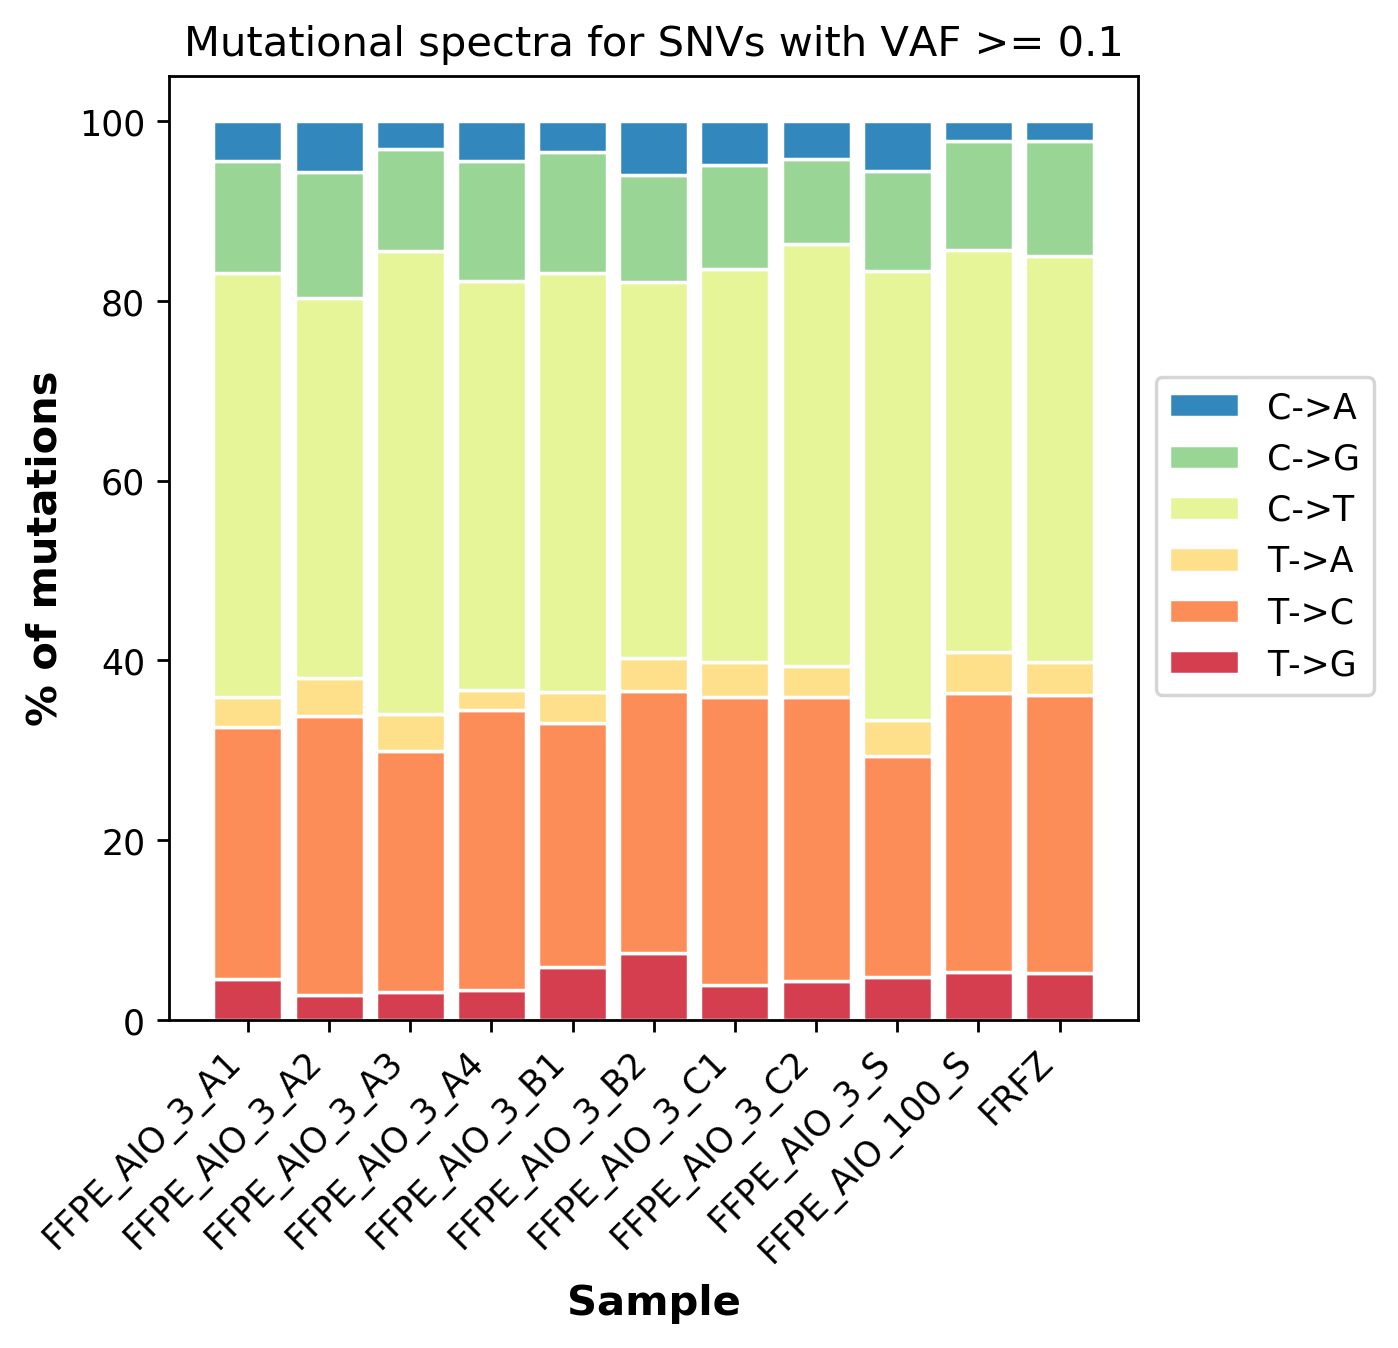

In [28]:
muts = ['C->A',
        'C->G',
        'C->T', 
        'T->A',
        'T->C',
        'T->G',]

mut_dict = {}
for mut in muts:
    mut_dict[mut] = []
    
for s in samples:  
    sample = df_dct[s]
    mut_pcts = 100*sample['mut'].value_counts(normalize=True)
    for m in mut_dict.keys():
        if m in mut_pcts.index:
            mut_dict[m].append(mut_pcts[m])
        else:
            mut_dict[m].append(0)

names = samples

r = list(range(len(samples)))
barWidth = 0.85

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)

ax.bar(r, 
        mut_dict['T->G'], 
        color=colors[5], 
        edgecolor='white', 
        width=barWidth, 
        label='T->G')

ax.bar(r, 
        mut_dict['T->C'], 
        bottom=mut_dict['T->G'], 
        color=colors[4], 
        edgecolor='white', 
        width=barWidth, 
        label='T->C')

ax.bar(r, 
        mut_dict['T->A'], 
        bottom=[i+j for i,j in zip(mut_dict['T->G'], 
                                mut_dict['T->C'])], 
        color=colors[3], 
        edgecolor='white', 
        width=barWidth, 
        label='T->A')

ax.bar(r, 
        mut_dict['C->T'], 
        bottom=[i+j+k for i,j,k in zip(mut_dict['T->A'], 
                                       mut_dict['T->C'],
                                       mut_dict['T->G'])], 
        color=colors[2], 
        edgecolor='white', 
        width=barWidth, 
        label='C->T')

ax.bar(r, 
        mut_dict['C->G'], 
        bottom=[i+j+k+l for i,j,k,l in zip(mut_dict['T->A'], 
                                           mut_dict['T->C'],
                                           mut_dict['T->G'],
                                           mut_dict['C->T'])], 
        color=colors[1], 
        edgecolor='white', 
        width=barWidth, 
        label='C->G')

ax.bar(r, 
        mut_dict['C->A'], 
        bottom=[i+j+k+l+m for i,j,k,l,m in zip(mut_dict['T->A'], 
                                               mut_dict['T->C'],
                                               mut_dict['T->G'],
                                               mut_dict['C->T'],
                                               mut_dict['C->G'])], 
        color=colors[0], 
        edgecolor='white', 
        width=barWidth, 
        label='C->A')

plt.xticks(r, names,rotation=45,ha='right')

plt.xlabel('Sample',fontweight='bold',fontsize=12)
plt.ylabel('% of mutations',fontweight='bold',fontsize=12)
 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles = handles[::-1], labels=labels[::-1], loc='upper left', bbox_to_anchor=(1,0.7), ncol=1)    
plt.title('Mutational spectra for SNVs with VAF >= 0.1')
plt.show()
